In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef
import sqlite3

# Load dataset
dataset = pd.read_csv('combined_dataset_E.csv')

# Extract label and feature columns
X = dataset.iloc[:, 1:]  # Feature columns
Y = dataset['type']  # Label column

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Establish connection to SQLite database
conn = sqlite3.connect('results_database.db')
cursor = conn.cursor()

# Drop existing table
cursor.execute('DROP TABLE IF EXISTS y_scrambling_results')
conn.commit()

# Create a new table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS y_scrambling_results (
        AUC REAL,
        ACC REAL,
        MCC REAL
    )
''')
conn.commit()

# Define a function to perform Y Scrambling and evaluate the model
def perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=5):
    original_score = model.fit(X_train, Y_train).score(X_val, Y_val)
    if len(model.classes_) > 1:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
    else:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val))

    original_acc = accuracy_score(Y_val, model.predict(X_val))
    original_mcc = matthews_corrcoef(Y_val, model.predict(X_val))
    print("Original Model Score:", original_score)
    print("Original AUC:", original_auc)
    print("Original ACC:", original_acc)
    print("Original MCC:", original_mcc)

    auc_list, acc_list, mcc_list = [], [], []
    for i in range(num_iterations):
        Y_train_scrambled = np.random.permutation(Y_train)
        model.fit(X_train, Y_train_scrambled)
        score = model.score(X_val, Y_val)
        if len(model.classes_) > 1:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
        else:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val))
        acc = accuracy_score(Y_val, model.predict(X_val))
        mcc = matthews_corrcoef(Y_val, model.predict(X_val))
        auc_list.append(auc)
        acc_list.append(acc)
        mcc_list.append(mcc)
        print(f"Iteration {i + 1} - Score: {score}, AUC: {auc}, ACC: {acc}, MCC: {mcc}")

        # Insert the results into the database
        cursor.execute('''
            INSERT INTO y_scrambling_results (AUC, ACC, MCC)
            VALUES (?, ?, ?)
        ''', (auc, acc, mcc))
        conn.commit()

    avg_auc = np.mean(auc_list)
    avg_acc = np.mean(acc_list)
    avg_mcc = np.mean(mcc_list)
    print("Y Scrambling Average AUC:", avg_auc)
    print("Y Scrambling Average ACC:", avg_acc)
    print("Y Scrambling Average MCC:", avg_mcc)

    score_difference = original_score - np.mean([score])
    print("Score Difference:", score_difference)

    return original_score, np.mean([score]), score_difference

# Create an instance of the model (replace with your desired model)
model = RandomForestClassifier()

# Perform Y Scrambling and evaluate the model
original_score, avg_score, score_difference = perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=100)

# Output CSV file to the working directory
results_df = pd.read_sql_query('SELECT * FROM y_scrambling_results', conn)
results_df.to_csv('y_scrambling_results_RF_E.csv', index=False)

# Close the database connection
conn.close()


Original Model Score: 0.9063444108761329
Original AUC: 0.9296432964329643
Original ACC: 0.9063444108761329
Original MCC: 0.6599596423089966
Iteration 1 - Score: 0.7734138972809668, AUC: 0.5285670356703567, ACC: 0.7734138972809668, MCC: -0.005217812635422503
Iteration 2 - Score: 0.7915407854984894, AUC: 0.566820418204182, ACC: 0.7915407854984894, MCC: 0.010593354528490265
Iteration 3 - Score: 0.7854984894259819, AUC: 0.5463407134071341, ACC: 0.7854984894259819, MCC: -0.027109875029899817
Iteration 4 - Score: 0.7613293051359517, AUC: 0.5353936039360394, ACC: 0.7613293051359517, MCC: -0.0668998120041671
Iteration 5 - Score: 0.7552870090634441, AUC: 0.5010147601476014, ACC: 0.7552870090634441, MCC: -0.12246719764195642
Iteration 6 - Score: 0.770392749244713, AUC: 0.4736162361623617, ACC: 0.770392749244713, MCC: -0.031102614811792238
Iteration 7 - Score: 0.8096676737160121, AUC: 0.5691266912669126, ACC: 0.8096676737160121, MCC: 0.10672411109373484
Iteration 8 - Score: 0.743202416918429, AUC

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef
import sqlite3
import xgboost as xgb

# Load dataset
dataset = pd.read_csv('combined_dataset_E.csv')

# Extract label and feature columns
X = dataset.iloc[:, 1:]  # Feature columns
Y = dataset['type']  # Label column

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Establish connection to SQLite database
conn = sqlite3.connect('results_database.db')
cursor = conn.cursor()

# Drop existing table
cursor.execute('DROP TABLE IF EXISTS y_scrambling_results')
conn.commit()

# Create a new table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS y_scrambling_results (
        AUC REAL,
        ACC REAL,
        MCC REAL
    )
''')
conn.commit()

# Define a function to perform Y Scrambling and evaluate the model
def perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=5):
    original_score = model.fit(X_train, Y_train).score(X_val, Y_val)
    if len(model.classes_) > 1:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
    else:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val))

    original_acc = accuracy_score(Y_val, model.predict(X_val))
    original_mcc = matthews_corrcoef(Y_val, model.predict(X_val))
    print("Original Model Score:", original_score)
    print("Original AUC:", original_auc)
    print("Original ACC:", original_acc)
    print("Original MCC:", original_mcc)

    auc_list, acc_list, mcc_list = [], [], []
    for i in range(num_iterations):
        Y_train_scrambled = np.random.permutation(Y_train)
        model.fit(X_train, Y_train_scrambled)
        score = model.score(X_val, Y_val)
        if len(model.classes_) > 1:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
        else:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val))
        acc = accuracy_score(Y_val, model.predict(X_val))
        mcc = matthews_corrcoef(Y_val, model.predict(X_val))
        auc_list.append(auc)
        acc_list.append(acc)
        mcc_list.append(mcc)
        print(f"Iteration {i + 1} - Score: {score}, AUC: {auc}, ACC: {acc}, MCC: {mcc}")

        # Insert the results into the database
        cursor.execute('''
            INSERT INTO y_scrambling_results (AUC, ACC, MCC)
            VALUES (?, ?, ?)
        ''', (auc, acc, mcc))
        conn.commit()

    avg_auc = np.mean(auc_list)
    avg_acc = np.mean(acc_list)
    avg_mcc = np.mean(mcc_list)
    print("Y Scrambling Average AUC:", avg_auc)
    print("Y Scrambling Average ACC:", avg_acc)
    print("Y Scrambling Average MCC:", avg_mcc)

    score_difference = original_score - np.mean([score])
    print("Score Difference:", score_difference)

    return original_score, np.mean([score]), score_difference

# Create an instance of the model (replace with your desired model)
model = xgb.XGBClassifier()

# Perform Y Scrambling and evaluate the model
original_score, avg_score, score_difference = perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=100)

# Output CSV file to the working directory
results_df = pd.read_sql_query('SELECT * FROM y_scrambling_results', conn)
results_df.to_csv('y_scrambling_results_XGB_E.csv', index=False)

# Close the database connection
conn.close()


Original Model Score: 0.9093655589123867
Original AUC: 0.9347478474784747
Original ACC: 0.9093655589123867
Original MCC: 0.672452188425381
Iteration 1 - Score: 0.770392749244713, AUC: 0.5640221402214023, ACC: 0.770392749244713, MCC: -0.0782551855888258
Iteration 2 - Score: 0.7764350453172205, AUC: 0.5480934809348094, ACC: 0.7764350453172205, MCC: 0.0003804601200219234
Iteration 3 - Score: 0.7673716012084593, AUC: 0.5821648216482165, ACC: 0.7673716012084593, MCC: -0.0360588123197948
Iteration 4 - Score: 0.7522658610271903, AUC: 0.4426814268142681, ACC: 0.7522658610271903, MCC: -0.10132029997659814
Iteration 5 - Score: 0.7613293051359517, AUC: 0.5017835178351784, ACC: 0.7613293051359517, MCC: -0.09029525921379167
Iteration 6 - Score: 0.7734138972809668, AUC: 0.5256457564575646, ACC: 0.7734138972809668, MCC: -0.005217812635422503
Iteration 7 - Score: 0.7673716012084593, AUC: 0.588068880688807, ACC: 0.7673716012084593, MCC: -0.0360588123197948
Iteration 8 - Score: 0.7854984894259819, AUC: 

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef
import sqlite3
from sklearn.linear_model import LogisticRegression

# Load dataset
dataset = pd.read_csv('combined_dataset_E.csv')

# Extract label and feature columns
X = dataset.iloc[:, 1:]  # Feature columns
Y = dataset['type']  # Label column

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Establish connection to SQLite database
conn = sqlite3.connect('results_database.db')
cursor = conn.cursor()

# Drop existing table
cursor.execute('DROP TABLE IF EXISTS y_scrambling_results')
conn.commit()

# Create a new table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS y_scrambling_results (
        AUC REAL,
        ACC REAL,
        MCC REAL
    )
''')
conn.commit()

# Define a function to perform Y Scrambling and evaluate the model
def perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=5):
    original_score = model.fit(X_train, Y_train).score(X_val, Y_val)
    if len(model.classes_) > 1:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
    else:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val))

    original_acc = accuracy_score(Y_val, model.predict(X_val))
    original_mcc = matthews_corrcoef(Y_val, model.predict(X_val))
    print("Original Model Score:", original_score)
    print("Original AUC:", original_auc)
    print("Original ACC:", original_acc)
    print("Original MCC:", original_mcc)

    auc_list, acc_list, mcc_list = [], [], []
    for i in range(num_iterations):
        Y_train_scrambled = np.random.permutation(Y_train)
        model.fit(X_train, Y_train_scrambled)
        score = model.score(X_val, Y_val)
        if len(model.classes_) > 1:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
        else:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val))
        acc = accuracy_score(Y_val, model.predict(X_val))
        mcc = matthews_corrcoef(Y_val, model.predict(X_val))
        auc_list.append(auc)
        acc_list.append(acc)
        mcc_list.append(mcc)
        print(f"Iteration {i + 1} - Score: {score}, AUC: {auc}, ACC: {acc}, MCC: {mcc}")

        # Insert the results into the database
        cursor.execute('''
            INSERT INTO y_scrambling_results (AUC, ACC, MCC)
            VALUES (?, ?, ?)
        ''', (auc, acc, mcc))
        conn.commit()

    avg_auc = np.mean(auc_list)
    avg_acc = np.mean(acc_list)
    avg_mcc = np.mean(mcc_list)
    print("Y Scrambling Average AUC:", avg_auc)
    print("Y Scrambling Average ACC:", avg_acc)
    print("Y Scrambling Average MCC:", avg_mcc)

    score_difference = original_score - np.mean([score])
    print("Score Difference:", score_difference)

    return original_score, np.mean([score]), score_difference

# Create an instance of the model (replace with your desired model)
model = LogisticRegression()

# Perform Y Scrambling and evaluate the model
original_score, avg_score, score_difference = perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=100)

# Output CSV file to the working directory
results_df = pd.read_sql_query('SELECT * FROM y_scrambling_results', conn)
results_df.to_csv('y_scrambling_results_LR_E.csv', index=False)

# Close the database connection
conn.close()


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Original Model Score: 0.9063444108761329
Original AUC: 0.9193111931119311
Original ACC: 0.9063444108761329
Original MCC: 0.6599596423089966
Iteration 1 - Score: 0.7583081570996979, AUC: 0.5713407134071341, ACC: 0.7583081570996979, MCC: -0.04993283157723561


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 2 - Score: 0.7613293051359517, AUC: 0.5105781057810578, ACC: 0.7613293051359517, MCC: -0.11611557662933801
Iteration 3 - Score: 0.7552870090634441, AUC: 0.5297662976629766, ACC: 0.7552870090634441, MCC: -0.054273595847631674


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 4 - Score: 0.7643504531722054, AUC: 0.5924354243542436, ACC: 0.7643504531722054, MCC: -0.002128528198918936
Iteration 5 - Score: 0.7280966767371602, AUC: 0.5335793357933579, ACC: 0.7280966767371602, MCC: -0.10754030497461084


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 6 - Score: 0.7643504531722054, AUC: 0.47859778597785985, ACC: 0.7643504531722054, MCC: -0.020783330250842336
Iteration 7 - Score: 0.7492447129909365, AUC: 0.4395448954489545, ACC: 0.7492447129909365, MCC: 0.0072935159392252796


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 8 - Score: 0.7190332326283988, AUC: 0.56309963099631, ACC: 0.7190332326283988, MCC: -0.08170095507890611
Iteration 9 - Score: 0.7311178247734139, AUC: 0.5718942189421894, ACC: 0.7311178247734139, MCC: -0.06737103383036959


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 10 - Score: 0.743202416918429, AUC: 0.5060270602706027, ACC: 0.743202416918429, MCC: -0.03428624014360046
Iteration 11 - Score: 0.7220543806646526, AUC: 0.41740467404674053, ACC: 0.7220543806646526, MCC: -0.09565169443269887


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 12 - Score: 0.7552870090634441, AUC: 0.5526445264452644, ACC: 0.7552870090634441, MCC: -0.054273595847631674
Iteration 13 - Score: 0.7462235649546828, AUC: 0.5990774907749076, ACC: 0.7462235649546828, MCC: -0.08667366825997909


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 14 - Score: 0.7824773413897281, AUC: 0.592189421894219, ACC: 0.7824773413897281, MCC: 0.06666517372833748
Iteration 15 - Score: 0.7401812688821753, AUC: 0.5947724477244773, ACC: 0.7401812688821753, MCC: -0.09391568192366843


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 16 - Score: 0.797583081570997, AUC: 0.5735547355473555, ACC: 0.797583081570997, MCC: 0.10273637135519677
Iteration 17 - Score: 0.770392749244713, AUC: 0.6086715867158672, ACC: 0.770392749244713, MCC: -0.010597975470951653


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 18 - Score: 0.7462235649546828, AUC: 0.4887453874538745, ACC: 0.7462235649546828, MCC: 0.002749893313138973
Iteration 19 - Score: 0.7552870090634441, AUC: 0.4854858548585486, ACC: 0.7552870090634441, MCC: -0.054273595847631674


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 20 - Score: 0.7552870090634441, AUC: 0.5897908979089791, ACC: 0.7552870090634441, MCC: 0.032181699195756905
Iteration 21 - Score: 0.7673716012084593, AUC: 0.529889298892989, ACC: 0.7673716012084593, MCC: 0.003029626562467478


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 22 - Score: 0.7583081570996979, AUC: 0.5814268142681426, ACC: 0.7583081570996979, MCC: -0.04993283157723561
Iteration 23 - Score: 0.7673716012084593, AUC: 0.5439114391143912, ACC: 0.7673716012084593, MCC: -0.0360588123197948


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 24 - Score: 0.7371601208459214, AUC: 0.5510455104551045, ACC: 0.7371601208459214, MCC: -0.07805339180804449
Iteration 25 - Score: 0.7583081570996979, AUC: 0.4087945879458795, ACC: 0.7583081570996979, MCC: 0.005291430320985693


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 26 - Score: 0.7643504531722054, AUC: 0.5247847478474785, ACC: 0.7643504531722054, MCC: -0.002128528198918936
Iteration 27 - Score: 0.7734138972809668, AUC: 0.48776137761377614, ACC: 0.7734138972809668, MCC: 0.013897628873431184
Iteration 28 - Score: 0.7341389728096677, AUC: 0.4357933579335793, ACC: 0.7341389728096677, MCC: -0.06361854736820773


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 29 - Score: 0.7673716012084593, AUC: 0.5891758917589176, ACC: 0.7673716012084593, MCC: 0.003029626562467478
Iteration 30 - Score: 0.7583081570996979, AUC: 0.5825338253382534, ACC: 0.7583081570996979, MCC: -0.04993283157723561


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 31 - Score: 0.7824773413897281, AUC: 0.6947109471094711, ACC: 0.7824773413897281, MCC: 0.12494341673755585
Iteration 32 - Score: 0.7613293051359517, AUC: 0.5452644526445265, ACC: 0.7613293051359517, MCC: -0.04545869573438458


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 33 - Score: 0.7280966767371602, AUC: 0.5295202952029521, ACC: 0.7280966767371602, MCC: -0.07105129749623941
Iteration 34 - Score: 0.7643504531722054, AUC: 0.5870233702337022, ACC: 0.7643504531722054, MCC: -0.04083875030616715


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 35 - Score: 0.7613293051359517, AUC: 0.540528905289053, ACC: 0.7613293051359517, MCC: -0.04545869573438458
Iteration 36 - Score: 0.7583081570996979, AUC: 0.555289052890529, ACC: 0.7583081570996979, MCC: 0.005291430320985693


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 37 - Score: 0.7734138972809668, AUC: 0.52539975399754, ACC: 0.7734138972809668, MCC: -0.005217812635422503
Iteration 38 - Score: 0.7583081570996979, AUC: 0.6251537515375154, ACC: 0.7583081570996979, MCC: -0.04993283157723561


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 39 - Score: 0.743202416918429, AUC: 0.5629766297662977, ACC: 0.743202416918429, MCC: -0.07050458369401555
Iteration 40 - Score: 0.7734138972809668, AUC: 0.6256457564575646, ACC: 0.7734138972809668, MCC: -0.005217812635422503


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Iteration 41 - Score: 0.7311178247734139, AUC: 0.520479704797048, ACC: 0.7311178247734139, MCC: -0.10422935197872607


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 42 - Score: 0.7522658610271903, AUC: 0.4574415744157442, ACC: 0.7522658610271903, MCC: -0.12555183960723473
Iteration 43 - Score: 0.7734138972809668, AUC: 0.5809963099630996, ACC: 0.7734138972809668, MCC: -0.005217812635422503


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 44 - Score: 0.7280966767371602, AUC: 0.49501845018450186, ACC: 0.7280966767371602, MCC: -0.10754030497461084
Iteration 45 - Score: 0.770392749244713, AUC: 0.5216482164821648, ACC: 0.770392749244713, MCC: 0.02605318515476778


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 46 - Score: 0.743202416918429, AUC: 0.5011685116851168, ACC: 0.743202416918429, MCC: -0.07050458369401555
Iteration 47 - Score: 0.7552870090634441, AUC: 0.54920049200492, ACC: 0.7552870090634441, MCC: 0.0004744887040002705


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 48 - Score: 0.7492447129909365, AUC: 0.5388068880688807, ACC: 0.7492447129909365, MCC: -0.10481502034220035
Iteration 49 - Score: 0.7492447129909365, AUC: 0.48474784747847477, ACC: 0.7492447129909365, MCC: -0.0625976256756892


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 50 - Score: 0.7673716012084593, AUC: 0.4977244772447724, ACC: 0.7673716012084593, MCC: 0.020614479138178776
Iteration 51 - Score: 0.770392749244713, AUC: 0.5309963099630997, ACC: 0.770392749244713, MCC: -0.031102614811792238


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 52 - Score: 0.7220543806646526, AUC: 0.5899753997539976, ACC: 0.7220543806646526, MCC: -0.11399591382485068
Iteration 53 - Score: 0.7583081570996979, AUC: 0.5415744157441574, ACC: 0.7583081570996979, MCC: -0.09406876467542057


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 54 - Score: 0.7734138972809668, AUC: 0.6095325953259534, ACC: 0.7734138972809668, MCC: 0.0483518474094681
Iteration 55 - Score: 0.7583081570996979, AUC: 0.5787207872078721, ACC: 0.7583081570996979, MCC: 0.03713618554507819


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Iteration 56 - Score: 0.7462235649546828, AUC: 0.5286592865928659, ACC: 0.7462235649546828, MCC: -0.04778321926223444


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 57 - Score: 0.7885196374622356, AUC: 0.6632841328413284, ACC: 0.7885196374622356, MCC: 0.09581467505473076
Iteration 58 - Score: 0.7492447129909365, AUC: 0.5706027060270602, ACC: 0.7492447129909365, MCC: -0.0625976256756892


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 59 - Score: 0.7885196374622356, AUC: 0.4970479704797048, ACC: 0.7885196374622356, MCC: 0.08012434903469483
Iteration 60 - Score: 0.7311178247734139, AUC: 0.5033825338253383, ACC: 0.7311178247734139, MCC: -0.12433853341193747


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 61 - Score: 0.7492447129909365, AUC: 0.5578720787207871, ACC: 0.7492447129909365, MCC: -0.025701471466681315
Iteration 62 - Score: 0.7522658610271903, AUC: 0.5315498154981549, ACC: 0.7522658610271903, MCC: -0.07908233290362889
Iteration 63 - Score: 0.7371601208459214, AUC: 0.5533825338253382, ACC: 0.7371601208459214, MCC: -0.04248285057383797


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 64 - Score: 0.7462235649546828, AUC: 0.4756457564575646, ACC: 0.7462235649546828, MCC: -0.04778321926223444
Iteration 65 - Score: 0.7250755287009063, AUC: 0.49766297662976633, ACC: 0.7250755287009063, MCC: -0.09225921708690123


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 66 - Score: 0.7522658610271903, AUC: 0.5800738007380074, ACC: 0.7522658610271903, MCC: -0.02124589447062437
Iteration 67 - Score: 0.7734138972809668, AUC: 0.6643911439114392, ACC: 0.7734138972809668, MCC: 0.0483518474094681


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 68 - Score: 0.797583081570997, AUC: 0.6415744157441574, ACC: 0.797583081570997, MCC: 0.10273637135519677
Iteration 69 - Score: 0.7462235649546828, AUC: 0.5531365313653136, ACC: 0.7462235649546828, MCC: -0.08667366825997909


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 70 - Score: 0.7734138972809668, AUC: 0.555350553505535, ACC: 0.7734138972809668, MCC: 0.07900236921604503
Iteration 71 - Score: 0.7734138972809668, AUC: 0.5201722017220172, ACC: 0.7734138972809668, MCC: -0.04868705756914348


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 72 - Score: 0.7673716012084593, AUC: 0.46906519065190655, ACC: 0.7673716012084593, MCC: -0.08240131709924076
Iteration 73 - Score: 0.7673716012084593, AUC: 0.5031980319803198, ACC: 0.7673716012084593, MCC: -0.08240131709924076
Iteration 74 - Score: 0.7764350453172205, AUC: 0.5555965559655597, ACC: 0.7764350453172205, MCC: -0.06948244728336615


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 75 - Score: 0.7794561933534743, AUC: 0.6356703567035671, ACC: 0.7794561933534743, MCC: 0.006220556070702548
Iteration 76 - Score: 0.7552870090634441, AUC: 0.5215252152521526, ACC: 0.7552870090634441, MCC: -0.03486025740439988


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 77 - Score: 0.7371601208459214, AUC: 0.4800123001230012, ACC: 0.7371601208459214, MCC: -0.07805339180804449
Iteration 78 - Score: 0.7492447129909365, AUC: 0.5134686346863468, ACC: 0.7492447129909365, MCC: -0.0625976256756892


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 79 - Score: 0.770392749244713, AUC: 0.5595940959409594, ACC: 0.770392749244713, MCC: 0.00836617107555094
Iteration 80 - Score: 0.7552870090634441, AUC: 0.5851783517835178, ACC: 0.7552870090634441, MCC: -0.016670633976093644


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 81 - Score: 0.7371601208459214, AUC: 0.5280442804428044, ACC: 0.7371601208459214, MCC: -0.026014726365881726
Iteration 82 - Score: 0.7522658610271903, AUC: 0.5073185731857319, ACC: 0.7522658610271903, MCC: -0.05849195490629237


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 83 - Score: 0.7764350453172205, AUC: 0.5340713407134071, ACC: 0.7764350453172205, MCC: 0.01964279936426384
Iteration 84 - Score: 0.743202416918429, AUC: 0.3928044280442805, ACC: 0.743202416918429, MCC: -0.11157681825773083


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 85 - Score: 0.7673716012084593, AUC: 0.4558425584255842, ACC: 0.7673716012084593, MCC: -0.0360588123197948
Iteration 86 - Score: 0.7613293051359517, AUC: 0.5057810578105781, ACC: 0.7613293051359517, MCC: -0.04545869573438458


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 87 - Score: 0.7673716012084593, AUC: 0.5554735547355474, ACC: 0.7673716012084593, MCC: -0.05812332078562693
Iteration 88 - Score: 0.7280966767371602, AUC: 0.4503690036900369, ACC: 0.7280966767371602, MCC: -0.10754030497461084


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 89 - Score: 0.7794561933534743, AUC: 0.5943419434194341, ACC: 0.7794561933534743, MCC: 0.04357579117733907
Iteration 90 - Score: 0.7522658610271903, AUC: 0.5890528905289053, ACC: 0.7522658610271903, MCC: -0.02124589447062437


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 91 - Score: 0.7462235649546828, AUC: 0.475830258302583, ACC: 0.7462235649546828, MCC: 0.002749893313138973
Iteration 92 - Score: 0.7250755287009063, AUC: 0.5265682656826568, ACC: 0.7250755287009063, MCC: -0.0746637344286323


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 93 - Score: 0.743202416918429, AUC: 0.5550430504305043, ACC: 0.743202416918429, MCC: -0.07050458369401555
Iteration 94 - Score: 0.7643504531722054, AUC: 0.5932964329643297, ACC: 0.7643504531722054, MCC: -0.002128528198918936


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 95 - Score: 0.7311178247734139, AUC: 0.49944649446494466, ACC: 0.7311178247734139, MCC: -0.06737103383036959
Iteration 96 - Score: 0.7552870090634441, AUC: 0.5157441574415744, ACC: 0.7552870090634441, MCC: -0.054273595847631674


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 97 - Score: 0.7371601208459214, AUC: 0.41217712177121774, ACC: 0.7371601208459214, MCC: -0.11807236221826786
Iteration 98 - Score: 0.7613293051359517, AUC: 0.5110086100861008, ACC: 0.7613293051359517, MCC: -0.007122889133110552


D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Iteration 99 - Score: 0.7522658610271903, AUC: 0.5511685116851168, ACC: 0.7522658610271903, MCC: -0.02124589447062437
Iteration 100 - Score: 0.7643504531722054, AUC: 0.5511685116851168, ACC: 0.7643504531722054, MCC: 0.015350014795959868
Y Scrambling Average AUC: 0.5384551045510456
Y Scrambling Average ACC: 0.7557099697885193
Y Scrambling Average MCC: -0.033458682563940384
Score Difference: 0.14199395770392753


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef
import sqlite3

# Load dataset
dataset = pd.read_csv('combined_dataset_ER.csv')

# Extract label and feature columns
X = dataset.iloc[:, 1:]  # Feature columns
Y = dataset['type']  # Label column

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Establish connection to SQLite database
conn = sqlite3.connect('results_database.db')
cursor = conn.cursor()

# Drop existing table
cursor.execute('DROP TABLE IF EXISTS y_scrambling_results')
conn.commit()

# Create a new table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS y_scrambling_results (
        AUC REAL,
        ACC REAL,
        MCC REAL
    )
''')
conn.commit()

# Define a function to perform Y Scrambling and evaluate the model
def perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=5):
    original_score = model.fit(X_train, Y_train).score(X_val, Y_val)
    if len(model.classes_) > 1:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
    else:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val))

    original_acc = accuracy_score(Y_val, model.predict(X_val))
    original_mcc = matthews_corrcoef(Y_val, model.predict(X_val))
    print("Original Model Score:", original_score)
    print("Original AUC:", original_auc)
    print("Original ACC:", original_acc)
    print("Original MCC:", original_mcc)

    auc_list, acc_list, mcc_list = [], [], []
    for i in range(num_iterations):
        Y_train_scrambled = np.random.permutation(Y_train)
        model.fit(X_train, Y_train_scrambled)
        score = model.score(X_val, Y_val)
        if len(model.classes_) > 1:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
        else:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val))
        acc = accuracy_score(Y_val, model.predict(X_val))
        mcc = matthews_corrcoef(Y_val, model.predict(X_val))
        auc_list.append(auc)
        acc_list.append(acc)
        mcc_list.append(mcc)
        print(f"Iteration {i + 1} - Score: {score}, AUC: {auc}, ACC: {acc}, MCC: {mcc}")

        # Insert the results into the database
        cursor.execute('''
            INSERT INTO y_scrambling_results (AUC, ACC, MCC)
            VALUES (?, ?, ?)
        ''', (auc, acc, mcc))
        conn.commit()

    avg_auc = np.mean(auc_list)
    avg_acc = np.mean(acc_list)
    avg_mcc = np.mean(mcc_list)
    print("Y Scrambling Average AUC:", avg_auc)
    print("Y Scrambling Average ACC:", avg_acc)
    print("Y Scrambling Average MCC:", avg_mcc)

    score_difference = original_score - np.mean([score])
    print("Score Difference:", score_difference)

    return original_score, np.mean([score]), score_difference

# Create an instance of the model (replace with your desired model)
model = xgb.XGBClassifier()

# Perform Y Scrambling and evaluate the model
original_score, avg_score, score_difference = perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=100)

# Output CSV file to the working directory
results_df = pd.read_sql_query('SELECT * FROM y_scrambling_results', conn)
results_df.to_csv('y_scrambling_results_XGB_ER.csv', index=False)

# Close the database connection
conn.close()


Original Model Score: 0.8942598187311178
Original AUC: 0.9127306273062731
Original ACC: 0.8942598187311178
Original MCC: 0.6174219741867157
Iteration 1 - Score: 0.7492447129909365, AUC: 0.49624846248462484, ACC: 0.7492447129909365, MCC: -0.0435876088350546
Iteration 2 - Score: 0.7462235649546828, AUC: 0.5428659286592866, ACC: 0.7462235649546828, MCC: -0.06659925774376137
Iteration 3 - Score: 0.770392749244713, AUC: 0.5433579335793357, ACC: 0.770392749244713, MCC: 0.042666438975866944
Iteration 4 - Score: 0.7522658610271903, AUC: 0.5419434194341943, ACC: 0.7522658610271903, MCC: -0.02124589447062437
Iteration 5 - Score: 0.7552870090634441, AUC: 0.5429274292742927, ACC: 0.7552870090634441, MCC: -0.03486025740439988
Iteration 6 - Score: 0.7583081570996979, AUC: 0.3755842558425585, ACC: 0.7583081570996979, MCC: -0.030310241552605654
Iteration 7 - Score: 0.7673716012084593, AUC: 0.5167281672816728, ACC: 0.7673716012084593, MCC: 0.020614479138178776
Iteration 8 - Score: 0.7854984894259819, A

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef
import sqlite3

# Load dataset
dataset = pd.read_csv('combined_dataset_R.csv')

# Extract label and feature columns
X = dataset.iloc[:, 1:]  # Feature columns
Y = dataset['type']  # Label column

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Establish connection to SQLite database
conn = sqlite3.connect('results_database.db')
cursor = conn.cursor()

# Drop existing table
cursor.execute('DROP TABLE IF EXISTS y_scrambling_results')
conn.commit()

# Create a new table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS y_scrambling_results (
        AUC REAL,
        ACC REAL,
        MCC REAL
    )
''')
conn.commit()

# Define a function to perform Y Scrambling and evaluate the model
def perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=5):
    original_score = model.fit(X_train, Y_train).score(X_val, Y_val)
    if len(model.classes_) > 1:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
    else:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val))

    original_acc = accuracy_score(Y_val, model.predict(X_val))
    original_mcc = matthews_corrcoef(Y_val, model.predict(X_val))
    print("Original Model Score:", original_score)
    print("Original AUC:", original_auc)
    print("Original ACC:", original_acc)
    print("Original MCC:", original_mcc)

    auc_list, acc_list, mcc_list = [], [], []
    for i in range(num_iterations):
        Y_train_scrambled = np.random.permutation(Y_train)
        model.fit(X_train, Y_train_scrambled)
        score = model.score(X_val, Y_val)
        if len(model.classes_) > 1:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
        else:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val))
        acc = accuracy_score(Y_val, model.predict(X_val))
        mcc = matthews_corrcoef(Y_val, model.predict(X_val))
        auc_list.append(auc)
        acc_list.append(acc)
        mcc_list.append(mcc)
        print(f"Iteration {i + 1} - Score: {score}, AUC: {auc}, ACC: {acc}, MCC: {mcc}")

        # Insert the results into the database
        cursor.execute('''
            INSERT INTO y_scrambling_results (AUC, ACC, MCC)
            VALUES (?, ?, ?)
        ''', (auc, acc, mcc))
        conn.commit()

    avg_auc = np.mean(auc_list)
    avg_acc = np.mean(acc_list)
    avg_mcc = np.mean(mcc_list)
    print("Y Scrambling Average AUC:", avg_auc)
    print("Y Scrambling Average ACC:", avg_acc)
    print("Y Scrambling Average MCC:", avg_mcc)

    score_difference = original_score - np.mean([score])
    print("Score Difference:", score_difference)

    return original_score, np.mean([score]), score_difference

# Create an instance of the model (replace with your desired model)
model = xgb.XGBClassifier()

# Perform Y Scrambling and evaluate the model
original_score, avg_score, score_difference = perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=100)

# Output CSV file to the working directory
results_df = pd.read_sql_query('SELECT * FROM y_scrambling_results', conn)
results_df.to_csv('y_scrambling_results_XGB_R.csv', index=False)

# Close the database connection
conn.close()


Original Model Score: 0.8972809667673716
Original AUC: 0.9106396063960639
Original ACC: 0.8972809667673716
Original MCC: 0.6302696768991991
Iteration 1 - Score: 0.7492447129909365, AUC: 0.5706642066420664, ACC: 0.7492447129909365, MCC: 0.0072935159392252796
Iteration 2 - Score: 0.7673716012084593, AUC: 0.5865313653136532, ACC: 0.7673716012084593, MCC: 0.05282640904536344
Iteration 3 - Score: 0.7734138972809668, AUC: 0.49114391143911434, ACC: 0.7734138972809668, MCC: -0.04868705756914348
Iteration 4 - Score: 0.7764350453172205, AUC: 0.4845018450184502, ACC: 0.7764350453172205, MCC: 0.01964279936426384
Iteration 5 - Score: 0.7643504531722054, AUC: 0.5392988929889299, ACC: 0.7643504531722054, MCC: -0.020783330250842336
Iteration 6 - Score: 0.7673716012084593, AUC: 0.5260762607626076, ACC: 0.7673716012084593, MCC: 0.003029626562467478
Iteration 7 - Score: 0.7462235649546828, AUC: 0.5212177121771218, ACC: 0.7462235649546828, MCC: -0.013241180911564766
Iteration 8 - Score: 0.7371601208459214

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef
import sqlite3

# Load dataset
dataset = pd.read_csv('combined_dataset_E.csv')

# Extract label and feature columns
X = dataset.iloc[:, 1:]  # Feature columns
Y = dataset['type']  # Label column

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Establish connection to SQLite database
conn = sqlite3.connect('results_database.db')
cursor = conn.cursor()

# Drop existing table
cursor.execute('DROP TABLE IF EXISTS y_scrambling_results')
conn.commit()

# Create a new table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS y_scrambling_results (
        AUC REAL,
        ACC REAL,
        MCC REAL
    )
''')
conn.commit()

# Define a function to perform Y Scrambling and evaluate the model
def perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=5):
    original_score = model.fit(X_train, Y_train).score(X_val, Y_val)
    if len(model.classes_) > 1:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
    else:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val))

    original_acc = accuracy_score(Y_val, model.predict(X_val))
    original_mcc = matthews_corrcoef(Y_val, model.predict(X_val))
    print("Original Model Score:", original_score)
    print("Original AUC:", original_auc)
    print("Original ACC:", original_acc)
    print("Original MCC:", original_mcc)

    auc_list, acc_list, mcc_list = [], [], []
    for i in range(num_iterations):
        Y_train_scrambled = np.random.permutation(Y_train)
        model.fit(X_train, Y_train_scrambled)
        score = model.score(X_val, Y_val)
        if len(model.classes_) > 1:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
        else:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val))
        acc = accuracy_score(Y_val, model.predict(X_val))
        mcc = matthews_corrcoef(Y_val, model.predict(X_val))
        auc_list.append(auc)
        acc_list.append(acc)
        mcc_list.append(mcc)
        print(f"Iteration {i + 1} - Score: {score}, AUC: {auc}, ACC: {acc}, MCC: {mcc}")

        # Insert the results into the database
        cursor.execute('''
            INSERT INTO y_scrambling_results (AUC, ACC, MCC)
            VALUES (?, ?, ?)
        ''', (auc, acc, mcc))
        conn.commit()

    avg_auc = np.mean(auc_list)
    avg_acc = np.mean(acc_list)
    avg_mcc = np.mean(mcc_list)
    print("Y Scrambling Average AUC:", avg_auc)
    print("Y Scrambling Average ACC:", avg_acc)
    print("Y Scrambling Average MCC:", avg_mcc)

    score_difference = original_score - np.mean([score])
    print("Score Difference:", score_difference)

    return original_score, np.mean([score]), score_difference

# Create an instance of the model (replace with your desired model)
model = xgb.XGBClassifier()

# Perform Y Scrambling and evaluate the model
original_score, avg_score, score_difference = perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=20)

# Output CSV file to the working directory
results_df = pd.read_sql_query('SELECT * FROM y_scrambling_results', conn)
results_df.to_csv('y_scrambling_results_XGB.csv', index=False)

# Close the database connection
conn.close()


Original Model Score: 0.9093655589123867
Original AUC: 0.9347478474784747
Original ACC: 0.9093655589123867
Original MCC: 0.672452188425381
Iteration 1 - Score: 0.7401812688821753, AUC: 0.5624231242312423, ACC: 0.7401812688821753, MCC: -0.09391568192366843
Iteration 2 - Score: 0.770392749244713, AUC: 0.599569495694957, ACC: 0.770392749244713, MCC: -0.010597975470951653
Iteration 3 - Score: 0.7885196374622356, AUC: 0.5023985239852399, ACC: 0.7885196374622356, MCC: 0.04524347285827921
Iteration 4 - Score: 0.7462235649546828, AUC: 0.5445264452644526, ACC: 0.7462235649546828, MCC: -0.06659925774376137
Iteration 5 - Score: 0.7643504531722054, AUC: 0.4654366543665437, ACC: 0.7643504531722054, MCC: -0.04083875030616715
Iteration 6 - Score: 0.7643504531722054, AUC: 0.5107626076260763, ACC: 0.7643504531722054, MCC: -0.0864100613491091
Iteration 7 - Score: 0.7613293051359517, AUC: 0.5150676506765067, ACC: 0.7613293051359517, MCC: -0.0256219846425821
Iteration 8 - Score: 0.7492447129909365, AUC: 0

In [28]:
#同时交叉验证
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef
import sqlite3
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb

# Load dataset
dataset = pd.read_csv('combined_dataset_E.csv')

# Extract label and feature columns
X = dataset.iloc[:, 1:]  # Feature columns
Y = dataset['type']  # Label column

# Establish connection to SQLite database
conn = sqlite3.connect('results_database.db')
cursor = conn.cursor()

# Drop existing table
cursor.execute('DROP TABLE IF EXISTS y_scrambling_results')
conn.commit()

# Create a new table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS y_scrambling_results (
        AUC REAL,
        ACC REAL,
        MCC REAL
    )
''')
conn.commit()

# Define a function to perform Y Scrambling and evaluate the model
def perform_y_scrambling(model, X, Y, num_iterations=5):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    auc_list, acc_list, mcc_list = [], [], []
    for train_index, val_index in skf.split(X, Y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]

        original_score = model.fit(X_train, Y_train).score(X_val, Y_val)
        if len(model.classes_) > 1:
            original_auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
        else:
            original_auc = roc_auc_score(Y_val, model.predict_proba(X_val))

        original_acc = accuracy_score(Y_val, model.predict(X_val))
        original_mcc = matthews_corrcoef(Y_val, model.predict(X_val))
        print("Original Model Score:", original_score)
        print("Original AUC:", original_auc)
        print("Original ACC:", original_acc)
        print("Original MCC:", original_mcc)

        for i in range(num_iterations):
            Y_train_scrambled = np.random.permutation(Y_train)
            model.fit(X_train, Y_train_scrambled)
            score = model.score(X_val, Y_val)
            if len(model.classes_) > 1:
                auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
            else:
                auc = roc_auc_score(Y_val, model.predict_proba(X_val))
            acc = accuracy_score(Y_val, model.predict(X_val))
            mcc = matthews_corrcoef(Y_val, model.predict(X_val))
            auc_list.append(auc)
            acc_list.append(acc)
            mcc_list.append(mcc)
            print(f"Iteration {i + 1} - Score: {score}, AUC: {auc}, ACC: {acc}, MCC: {mcc}")

            # Insert the results into the database
            cursor.execute('''
                INSERT INTO y_scrambling_results (AUC, ACC, MCC)
                VALUES (?, ?, ?)
            ''', (auc, acc, mcc))
            conn.commit()

    avg_auc = np.mean(auc_list)
    avg_acc = np.mean(acc_list)
    avg_mcc = np.mean(mcc_list)
    print("Y Scrambling Average AUC:", avg_auc)
    print("Y Scrambling Average ACC:", avg_acc)
    print("Y Scrambling Average MCC:", avg_mcc)

    score_difference = original_score - np.mean([score])
    print("Score Difference:", score_difference)

    return original_score, np.mean([score]), score_difference

# Create an instance of the model (replace with your desired model)
model = xgb.XGBClassifier()

# Perform Y Scrambling and evaluate the model
original_score, avg_score, score_difference = perform_y_scrambling(model, X, Y, num_iterations=20)

# Output CSV file to the working directory
results_df = pd.read_sql_query('SELECT * FROM y_scrambling_results', conn)
results_df.to_csv('y_scrambling_results-XGB.csv', index=False)

# Close the database connection
conn.close()


Original Model Score: 0.8942598187311178
Original AUC: 0.8898376623376625
Original ACC: 0.8942598187311178
Original MCC: 0.5926179319671626
Iteration 1 - Score: 0.7401812688821753, AUC: 0.5177597402597403, ACC: 0.7401812688821753, MCC: -0.07999318978277012
Iteration 2 - Score: 0.7643504531722054, AUC: 0.5253571428571429, ACC: 0.7643504531722054, MCC: -0.09509863347141848
Iteration 3 - Score: 0.7552870090634441, AUC: 0.6175649350649351, ACC: 0.7552870090634441, MCC: -0.12898433165864914
Iteration 4 - Score: 0.7492447129909365, AUC: 0.5100324675324676, ACC: 0.7492447129909365, MCC: -0.08974338503255247
Iteration 5 - Score: 0.7613293051359517, AUC: 0.5352922077922079, ACC: 0.7613293051359517, MCC: -0.0756031501191688
Iteration 6 - Score: 0.7824773413897281, AUC: 0.5427597402597403, ACC: 0.7824773413897281, MCC: 0.018007611906334736
Iteration 7 - Score: 0.8036253776435045, AUC: 0.566525974025974, ACC: 0.8036253776435045, MCC: 0.06185474530542495
Iteration 8 - Score: 0.7885196374622356, AUC

C:\Users\asus\AppData\Local\Temp\ipykernel_21656\4133510698.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Metric', y='Value', data=melted_data, inner="quartile", palette=colors, width=0.5, alpha=0.3)  # Adjust width here
C:\Users\asus\AppData\Local\Temp\ipykernel_21656\4133510698.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=melted_data, width=0.3, palette=colors, linewidth=1, ax=ax)


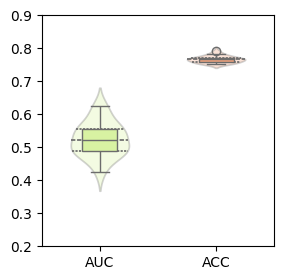

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv('y_scrambling_results_RF.csv')

# Melt the DataFrame to combine AUC, ACC, and MCC into a single column
melted_data = pd.melt(data, value_vars=['AUC', 'ACC'], var_name='Metric', value_name='Value')

# Set your preferred color palette
colors = ["#ddff95", "#ff9b6a"]

# Create a violin plot with box plots and error bars
plt.figure(figsize=(3, 3))
ax = sns.violinplot(x='Metric', y='Value', data=melted_data, inner="quartile", palette=colors, width=0.5, alpha=0.3)  # Adjust width here

# Add box plots
sns.boxplot(x='Metric', y='Value', data=melted_data, width=0.3, palette=colors, linewidth=1, ax=ax)

# Set Y-axis limits to be in the range of 0 to 1
ax.set_ylim(0.2, 0.9)

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.savefig('y_scrambling_RF.png')

# Show the plot
plt.show()


C:\Users\asus\AppData\Local\Temp\ipykernel_21656\1351450711.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Metric', y='Value', data=melted_data, inner="quartile", palette=colors, width=0.5, alpha=0.3)  # Adjust width here
C:\Users\asus\AppData\Local\Temp\ipykernel_21656\1351450711.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=melted_data, width=0.3, palette=colors, linewidth=1, ax=ax)


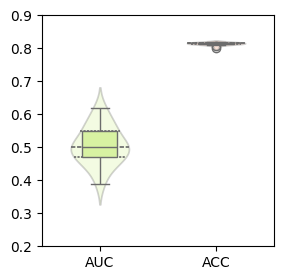

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv('y_scrambling_results_SVM.csv')

# Melt the DataFrame to combine AUC, ACC, and MCC into a single column
melted_data = pd.melt(data, value_vars=['AUC', 'ACC'], var_name='Metric', value_name='Value')

# Set your preferred color palette
colors = ["#ddff95", "#ff9b6a"]

# Create a violin plot with box plots and error bars
plt.figure(figsize=(3, 3))
ax = sns.violinplot(x='Metric', y='Value', data=melted_data, inner="quartile", palette=colors, width=0.5, alpha=0.3)  # Adjust width here

# Add box plots
sns.boxplot(x='Metric', y='Value', data=melted_data, width=0.3, palette=colors, linewidth=1, ax=ax)

# Set Y-axis limits to be in the range of 0 to 1
ax.set_ylim(0.2, 0.9)

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.savefig('y_scrambling_SVM.png')

# Show the plot
plt.show()


C:\Users\asus\AppData\Local\Temp\ipykernel_21656\1182484873.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Metric', y='Value', data=melted_data, inner="quartile", palette=colors, width=0.5, alpha=0.3)  # Adjust width here
C:\Users\asus\AppData\Local\Temp\ipykernel_21656\1182484873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=melted_data, width=0.3, palette=colors, linewidth=1, ax=ax)


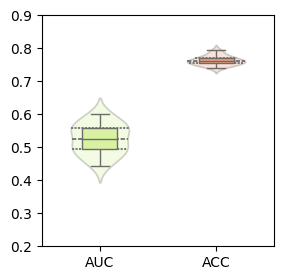

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv('y_scrambling_results_XGB.csv')

# Melt the DataFrame to combine AUC, ACC, and MCC into a single column
melted_data = pd.melt(data, value_vars=['AUC', 'ACC'], var_name='Metric', value_name='Value')

# Set your preferred color palette
colors = ["#ddff95", "#ff9b6a"]

# Create a violin plot with box plots and error bars
plt.figure(figsize=(3, 3))
ax = sns.violinplot(x='Metric', y='Value', data=melted_data, inner="quartile", palette=colors, width=0.5, alpha=0.3)  # Adjust width here

# Add box plots
sns.boxplot(x='Metric', y='Value', data=melted_data, width=0.3, palette=colors, linewidth=1, ax=ax)

# Set Y-axis limits to be in the range of 0 to 1
ax.set_ylim(0.2,0.9)

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.savefig('y_scrambling_XGB.png')

# Show the plot
plt.show()


C:\Users\asus\AppData\Local\Temp\ipykernel_21656\2039436801.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Metric', y='Value', data=melted_data, inner="quartile", palette=colors, width=0.5, alpha=0.3)  # Adjust width here
C:\Users\asus\AppData\Local\Temp\ipykernel_21656\2039436801.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=melted_data, width=0.3, palette=colors, linewidth=1, ax=ax)


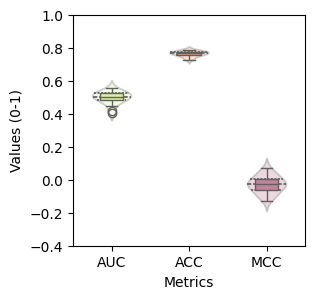

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv('y_scrambling_results.csv')

# Melt the DataFrame to combine AUC, ACC, and MCC into a single column
melted_data = pd.melt(data, value_vars=['AUC', 'ACC','MCC'], var_name='Metric', value_name='Value')

# Set your preferred color palette
colors = ["#ddff95", "#ff9b6a", "#cb7799"]

# Create a violin plot with box plots and error bars
plt.figure(figsize=(3, 3))
ax = sns.violinplot(x='Metric', y='Value', data=melted_data, inner="quartile", palette=colors, width=0.5, alpha=0.3)  # Adjust width here

# Add box plots
sns.boxplot(x='Metric', y='Value', data=melted_data, width=0.3, palette=colors, linewidth=1, ax=ax)

# Set Y-axis limits to be in the range of 0 to 1
ax.set_ylim(-0.4, 1)

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values (0-1)')
plt.savefig('y_scrambling_F.png')

# Show the plot
plt.show()


C:\Users\asus\AppData\Local\Temp\ipykernel_21656\1844101365.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Metric', y='Value', data=melted_data, inner=None, palette=colors, width=0.5, alpha=0.3)  # Adjust width here
C:\Users\asus\AppData\Local\Temp\ipykernel_21656\1844101365.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=melted_data, width=0.3, palette=colors, linewidth=1, ax=ax)


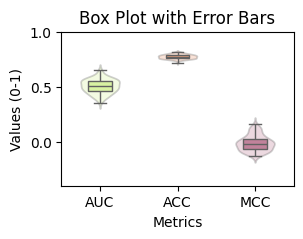

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv('y_scrambling_results-cv.csv')

# Melt the DataFrame to combine AUC, ACC, and MCC into a single column
melted_data = pd.melt(data, value_vars=['AUC', 'ACC','MCC'], var_name='Metric', value_name='Value')

# Set your preferred color palette
colors = ["#ddff95", "#ff9b6a", "#cb7799"]

# Create a violin plot with only box plots and error bars
plt.figure(figsize=(3, 2))
ax = sns.violinplot(x='Metric', y='Value', data=melted_data, inner=None, palette=colors, width=0.5, alpha=0.3)  # Adjust width here

# Add box plots
sns.boxplot(x='Metric', y='Value', data=melted_data, width=0.3, palette=colors, linewidth=1, ax=ax)

# Set Y-axis limits to be in the range of 0 to 1
ax.set_ylim(-0.4, 1)

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values (0-1)')
plt.title('Box Plot with Error Bars')

# Show the plot
plt.show()


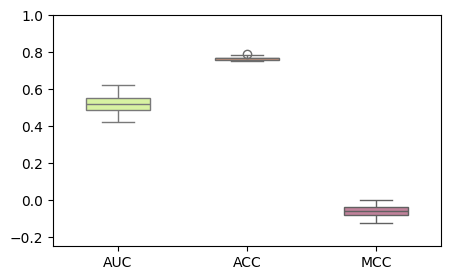

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv('y_scrambling_results_RF.csv')

# Melt the DataFrame to combine AUC, ACC, and MCC into a single column
melted_data = pd.melt(data, value_vars=['AUC', 'ACC','MCC'], var_name='Metric', value_name='Value')

# Set your preferred color palette
colors = ["#ddff95", "#ff9b6a", "#cb7799"]

# Create a figure and axis
plt.figure(figsize=(5, 3))

# Plot for AUC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'AUC'],
            width=0.5, color=colors[0], linewidth=1)

# Plot for ACC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'ACC'],
            width=0.5, color=colors[1], linewidth=1)

# Plot for ACC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'MCC'],
            width=0.5, color=colors[2], linewidth=1)

# Set Y-axis limits to be in the range of 0 to 1
plt.ylim(-0.25, 1)

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.savefig('y_扰动_RF.png')

# Show the plot
plt.show()

# Show the plot
plt.show()


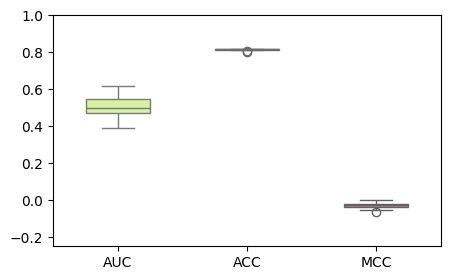

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv('y_scrambling_results_SVM.csv')

# Melt the DataFrame to combine AUC, ACC, and MCC into a single column
melted_data = pd.melt(data, value_vars=['AUC', 'ACC','MCC'], var_name='Metric', value_name='Value')

# Set your preferred color palette
colors = ["#ddff95", "#ff9b6a", "#cb7799"]

# Create a figure and axis
plt.figure(figsize=(5, 3))

# Plot for AUC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'AUC'],
            width=0.5, color=colors[0], linewidth=1)

# Plot for ACC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'ACC'],
            width=0.5, color=colors[1], linewidth=1)

# Plot for ACC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'MCC'],
            width=0.5, color=colors[2], linewidth=1)

# Set Y-axis limits to be in the range of 0 to 1
plt.ylim(-0.25, 1)

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.savefig('y_扰动_SVM.png')

# Show the plot
plt.show()

# Show the plot
plt.show()


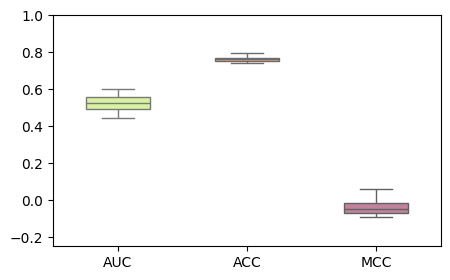

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv('y_scrambling_results_XGB.csv')

# Melt the DataFrame to combine AUC, ACC, and MCC into a single column
melted_data = pd.melt(data, value_vars=['AUC', 'ACC','MCC'], var_name='Metric', value_name='Value')

# Set your preferred color palette
colors = ["#ddff95", "#ff9b6a", "#cb7799"]

# Create a figure and axis
plt.figure(figsize=(5,3))

# Plot for AUC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'AUC'],
            width=0.5, color=colors[0], linewidth=1)

# Plot for ACC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'ACC'],
            width=0.5, color=colors[1], linewidth=1)

# Plot for ACC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'MCC'],
            width=0.5, color=colors[2], linewidth=1)

# Set Y-axis limits to be in the range of 0 to 1
plt.ylim(-0.25, 1)

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.savefig('y_扰动_XGB.png')

# Show the plot
plt.show()

# Show the plot
plt.show()


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef
import sqlite3
import lightgbm as lgb
# Load dataset
dataset = pd.read_csv('combined_dataset_M.csv')

# Extract label and feature columns
X = dataset.iloc[:, 1:]  # Feature columns
Y = dataset['type']  # Label column

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Establish connection to SQLite database
conn = sqlite3.connect('results_database.db')
cursor = conn.cursor()

# Drop existing table
cursor.execute('DROP TABLE IF EXISTS y_scrambling_results')
conn.commit()

# Create a new table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS y_scrambling_results (
        AUC REAL,
        ACC REAL,
        MCC REAL
    )
''')
conn.commit()

# Define a function to perform Y Scrambling and evaluate the model
def perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=5):
    original_score = model.fit(X_train, Y_train).score(X_val, Y_val)
    if len(model.classes_) > 1:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
    else:
        original_auc = roc_auc_score(Y_val, model.predict_proba(X_val))

    original_acc = accuracy_score(Y_val, model.predict(X_val))
    original_mcc = matthews_corrcoef(Y_val, model.predict(X_val))
    print("Original Model Score:", original_score)
    print("Original AUC:", original_auc)
    print("Original ACC:", original_acc)
    print("Original MCC:", original_mcc)

    auc_list, acc_list, mcc_list = [], [], []
    for i in range(num_iterations):
        Y_train_scrambled = np.random.permutation(Y_train)
        model.fit(X_train, Y_train_scrambled)
        score = model.score(X_val, Y_val)
        if len(model.classes_) > 1:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
        else:
            auc = roc_auc_score(Y_val, model.predict_proba(X_val))
        acc = accuracy_score(Y_val, model.predict(X_val))
        mcc = matthews_corrcoef(Y_val, model.predict(X_val))
        auc_list.append(auc)
        acc_list.append(acc)
        mcc_list.append(mcc)
        print(f"Iteration {i + 1} - Score: {score}, AUC: {auc}, ACC: {acc}, MCC: {mcc}")

        # Insert the results into the database
        cursor.execute('''
            INSERT INTO y_scrambling_results (AUC, ACC, MCC)
            VALUES (?, ?, ?)
        ''', (auc, acc, mcc))
        conn.commit()

    avg_auc = np.mean(auc_list)
    avg_acc = np.mean(acc_list)
    avg_mcc = np.mean(mcc_list)
    print("Y Scrambling Average AUC:", avg_auc)
    print("Y Scrambling Average ACC:", avg_acc)
    print("Y Scrambling Average MCC:", avg_mcc)

    score_difference = original_score - np.mean([score])
    print("Score Difference:", score_difference)

    return original_score, np.mean([score]), score_difference

# Create an instance of the model (replace with your desired model)
model = lgb.LGBMClassifier()

# Perform Y Scrambling and evaluate the model
original_score, avg_score, score_difference = perform_y_scrambling(model, X_train, X_val, Y_train, Y_val, num_iterations=20)

# Output CSV file to the working directory
results_df = pd.read_sql_query('SELECT * FROM y_scrambling_results', conn)
results_df.to_csv('y_scrambling_results_LGBM.csv', index=False)

# Close the database connection
conn.close()


[LightGBM] [Info] Number of positive: 216, number of negative: 1104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 1320, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163636 -> initscore=-1.631417
[LightGBM] [Info] Start training from score -1.631417
Original Model Score: 0.8942598187311178
Original AUC: 0.9125768757687577
Original ACC: 0.8942598187311178
Original MCC: 0.6209074190056456
[LightGBM] [Info] Number of positive: 216, number of negative: 1104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

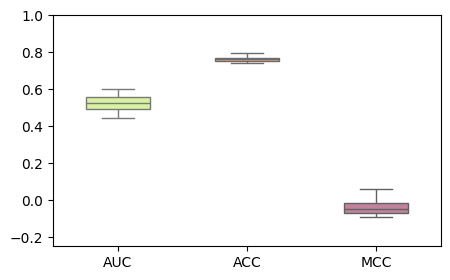

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv('y_scrambling_results_XGB.csv')

# Melt the DataFrame to combine AUC, ACC, and MCC into a single column
melted_data = pd.melt(data, value_vars=['AUC', 'ACC','MCC'], var_name='Metric', value_name='Value')

# Set your preferred color palette
colors = ["#ddff95", "#ff9b6a", "#cb7799"]

# Create a figure and axis
plt.figure(figsize=(5,3))

# Plot for AUC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'AUC'],
            width=0.5, color=colors[0], linewidth=1)

# Plot for ACC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'ACC'],
            width=0.5, color=colors[1], linewidth=1)

# Plot for ACC
sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Metric'] == 'MCC'],
            width=0.5, color=colors[2], linewidth=1)

# Set Y-axis limits to be in the range of 0 to 1
plt.ylim(-0.25, 1)

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.savefig('y_扰动_XGB.png')

# Show the plot
plt.show()

# Show the plot
plt.show()
